In [163]:
import jax.numpy as jnp
from jax import grad, jit, vmap,pmap
from jax import random
from jax import device_put
from jax import make_jaxpr
from jax import profiler
from jax import lax
from functools import partial
import tracemalloc

import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.ndimage import uniform_filter1d
from corner import corner
from emcee.autocorr import integrated_time

seed= 42
key= random.key(seed)


In [194]:
def logP(X):
    return -jnp.sum(100*(X[1:]-X[:-1]**2)**2 + (1-X[:-1])**2)


grad_logP= grad(logP)


def leapfrog(gradi,X,P,Ms,n,h):
    P- (h/2)*gradi(X)
    def step(i,val):
        X,P= val
        X-= h*P/Ms
        P-= h*gradi(X)
        return (X,P)
    
    X,P= lax.fori_loop(0, n,step,(X,P))
    P+= (h/2)*gradi(X) 

    return X,P


def HMC(logP,grad_logP,prop_means,Ms,X,n_iter,n_leap,step_size,key):
    n_dims= X.size
    accept_ratio= 0.
    sigs= jnp.sqrt(Ms)

   
    def step(val,i):
        key,X,accept_ratio= val
        key,prop,uni= random.split(key,3)
        P= prop_means + sigs*random.normal(prop,(n_dims))
        H_i= -logP(X)+ jnp.sum(P**2/Ms)/2
        Y,P= leapfrog(grad_logP,X,P,Ms,n_leap,step_size)
        H_f= -logP(Y)+ jnp.sum(P**2/Ms)/2
        u= jnp.log(random.uniform(uni))
        del_H= H_i-H_f
        X,accept_ratio= lax.cond(del_H>u,lambda H: (Y,accept_ratio+1),lambda H: (X,accept_ratio),del_H)
        return (key,X,accept_ratio),X

    val,chain= lax.scan(step,(key,X,accept_ratio),jnp.arange(0,n_iter))
    key,X,accept_ratio= val
    accept_ratio /= n_iter

    return chain,accept_ratio

HMC= jit(vmap(HMC,in_axes=(None,None,None,None,0,None,None,None,0),out_axes=(1,0)),static_argnums=(0,1,5,6))
#HMC= pmap(HMC,in_axes=(None,None,None,None,0,None,None,None,0),out_axes=(1,0),static_broadcasted_argnums=(0,1,5,6))


def discard_failed_chains(chains,accept_ratio,threshold=0.005):
    ids= np.where(accept_ratio>threshold)[0]
    return chains[:,ids,:],accept_ratio[ids]

def discard_bad_starts(chains,accept_ratio,burn_in,window):
    ids= np.where(np.any(np.all(chains[burn_in-window:burn_in]!=chains[burn_in],axis=0),axis=1))[0]
    return chains[:,ids,:], accept_ratio[ids]

def get_samples(chains,burn_in=0,thin=1,flatten=False):
    if flatten:
        return chains[burn_in::thin,:,:].reshape(-1,chains.shape[2])
    else:
        return chains[burn_in::thin,:,:]
    
    
def trace_plot(chains,plot_first=None,plot_chains=None,plot_dims=None):
    if not plot_first:
        plot_first= chains.shape[0]
    if not plot_chains:
        plot_chains= np.arange(chains.shape[1])
    if not plot_dims:
        plot_dims= np.arange(chains.shape[2])
    steps= np.arange(0,plot_first)
    n_plots= len(plot_dims)
    fig,axs=plt.subplots(n_plots,figsize=(8,2*n_plots))


    for i,dim in enumerate(plot_dims):
        for chain in plot_chains:
            axs[i].plot(steps,chains[:plot_first,chain,dim],lw=0.5)
            axs[i].set_title('X'+str(dim))

    plt.tight_layout()

    return fig,axs

In [188]:
n_dims=3
n_chains=100
n_iter=100000
n_leap=60
step_size= 0.005
Ms= jnp.array([1.,1.,1.])
means= jnp.zeros(n_dims)
X0= random.uniform(key,(n_chains,n_dims),minval=-2,maxval=2)
#X0= jnp.ones((n_chains,n_dims))

subkeys= random.split(key,n_chains+1)
key,subkeys= subkeys[0],subkeys[1:]

chains,accept_ratio= HMC(logP,grad_logP,means,Ms,X0,n_iter,n_leap,step_size,subkeys)
chains,accept_ratio= discard_failed_chains(chains,accept_ratio)
print(f'{len(accept_ratio)} chains converged with a mean acceptance ratio of: {jnp.mean(accept_ratio)}')

99 chains converged with a mean acceptance ratio of: 0.9619250893592834


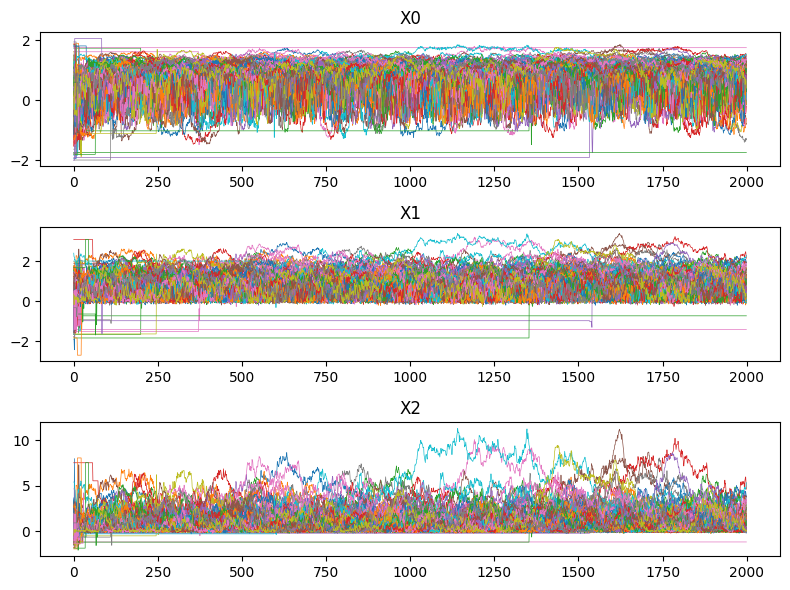

In [191]:
plot_first= 2000
trace_plot(chains,plot_first)
plt.show()

In [197]:
burn_in=500
window=200

chains,accept_ratio= discard_bad_starts(chains,accept_ratio,burn_in,window)
chains= get_samples(chains,burn_in= burn_in+window)


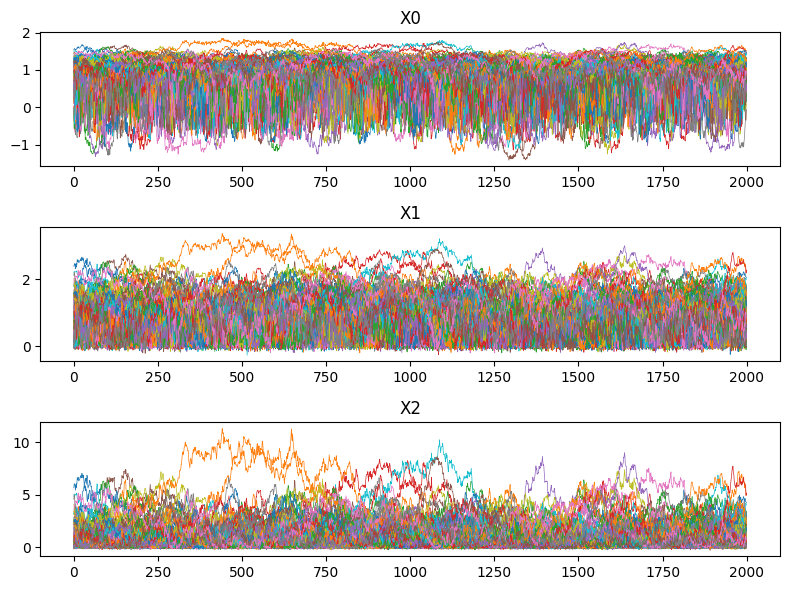

In [198]:
trace_plot(chains,plot_first)
plt.show()

In [200]:
iats= integrated_time(chains)
print(iats)
thinned_chains= get_samples(chains,thin= int(2*iats.max()),flatten=True)

[ 98.93086464 140.07793681 184.17650028]


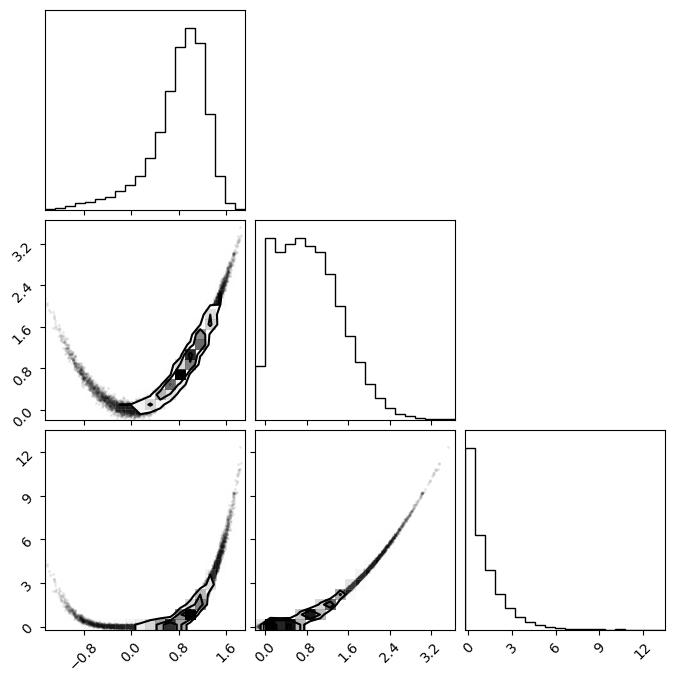

In [201]:
corner(np.array(thinned_chains))
plt.show()

In [202]:
#Calcuating the expectation from i.i.d samples
mod_X= np.sqrt(np.sum(thinned_chains**2,axis=1))
mean_X= np.mean(mod_X)
var_X= np.var(mod_X,ddof=1)
std_mean= (var_X/thinned_chains.shape[0])**0.5
print(f"Mean: {mean_X:.5f},\nUncertainty on mean: {std_mean:.5f}")

Mean: 1.73413,
Uncertainty on mean: 0.00909
